In [1]:
!pip install pandas
!pip install xlrd
!pip install 'pandas-profiling==2.8.0'
!pip install seaborn
from scipy.stats import chi2
from scipy.stats import chi2_contingency

You should consider upgrading via the '/Users/omalagonm/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/omalagonm/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/omalagonm/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/omalagonm/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot
from sklearn.decomposition import PCA
from scipy import stats

sns.set_style(style="whitegrid")

In [3]:
df_hurtos = pd.concat([
    pd.read_excel('data/hurto-de-automotores-2017_0.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2018_0.xls', skiprows=8),
    pd.read_excel('data/hurto-de-automotores-2018_1.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2019_0.xls', skiprows=8)
])


# Limpieza

In [4]:
# Correción de valores de edad y cantidad. 
# Edad -1 representa que no se conoce la edad del individuo
# Cantidad 1000 se borra en un paso posterior.
df_hurtos['Edad'] = df_hurtos['Edad'].fillna('-1')
df_hurtos['Edad'] = df_hurtos['Edad'].astype(str)
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-']
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-1']

# Corrección de tipos.
cols_str = [
    'Fecha','Hora', 'Departamento', 'Municipio', 'Día', 'Barrio', 'Zona', 'Clase de sitio', 
    'Arma empleada', 'Móvil Agresor', 'Móvil Victima', 'Sexo', 'Estado civil' ,
    'País de nacimiento','Clase de empleado', 'Profesión', 'Escolaridad', 'Código DANE', 'CLASE',
    'MARCA', 'LINEA', 'MODELO', 'COLOR']
for col in cols_str:
    df_hurtos[col] = df_hurtos[col].astype(str)

df_hurtos['Edad'] = df_hurtos['Edad'].astype('int64')

# Remoción de duplicados
df_hurtos.drop_duplicates(inplace=True)

# Remoción de valores atípicos/outliers. 
# 1. Constantes
df_hurtos.drop(columns=['Cantidad', 'Profesión', 'Zona', 'Barrio', 'País de nacimiento'], inplace=True)
# 2. Registros con edad mayor a 110
df_hurtos = df_hurtos[df_hurtos['Edad'] < 110]

# Creación de nuevas columnas
df_hurtos['Fecha'] = df_hurtos['Fecha'].apply(lambda x: x[:11])
df_hurtos['M'] = df_hurtos['Fecha'].apply(lambda x: x[5:7])
df_hurtos['Mes'] = df_hurtos['Fecha'].apply(lambda x: x[5:7]).astype(int)


# Categorización de la variable Hora
def hora_to_cat(hora):
    if hora == 'na':
        return "No_especificada"
    hora = int(hora)

    if hora > 0 and hora <= 4:
        return '(00-04]'
    if hora > 4 and hora <= 8:
        return '(04-08]'
    if hora > 8 and hora <= 12:
        return '(08-12]'
    if hora > 12 and hora <= 16:
        return '(12-16)'
    if hora > 16 and hora <= 20:
        return '(16-20]'
    if hora == 0 or hora > 20:
        return '(20-24]'
df_hurtos['Hora_Cat'] = df_hurtos['Hora'].apply(lambda hora: hora_to_cat(hora[:2]))


def mes_to_trimestre(mes):
    if mes <= 3:
        return 'PRIMER TIMESTRE'
    if mes > 3 and mes <= 6:
        return 'SEGUNDO TRIMESTRE'
    if mes > 6 and mes <= 9:
        return 'TERCER TRIMESTRE'
    if mes > 9:
        return 'CUARTO TRIMESTRE'
    
df_hurtos['Trimestre'] = df_hurtos['Mes'].apply(lambda mes: mes_to_trimestre(mes))


def edad_to_grupo_etario(x):
    if x['Edad']<=31:
        return 'de_0_a_31'
    elif x['Edad'] > 31 and x['Edad'] <=38:
        return 'de_32_a_38' 
    elif x['Edad'] > 38 and x['Edad'] <=49:
        return 'de_39_a_49'
    else: 
        return 'de_50_a_99' 

df_hurtos['Grupo_Etario'] = df_hurtos.apply(edad_to_grupo_etario,axis=1)

def multivariate_performance(df):
    try:
        pca = PCA(n_components=0.90)
        pca.fit(df)
        pca_transformed = pca.transform(df)
        df_pca = pd.DataFrame(pca_transformed)

        dict_ = dict()
        for column_pca in df_pca.columns:
            corr_list = []
            for column_transformed in df.columns:
                corr_list.append(stats.spearmanr(df[column_transformed].tolist(),df_pca[column_pca].tolist())[0])
            dict_[f"CORR_PCA_COMPONENT_{column_pca}"] = corr_list
        
        df = pd.DataFrame(dict_,index=df.columns)
    except:
        print("error")
    return df


In [5]:
colores_dict = {
    'ABANO': 'BLANCO', 'BEIGE': 'BLANCO', 'BLANCO': 'BLANCO', 'BLANCO Y VERDE': 'BLANCO', 'CHAMPAÑA': 'BLANCO', 'CREMA': 'BLANCO', 'MARFIL': 'BLANCO', 'PERLA': 'BLANCO',
    'SAHARA': 'BLANCO', 

    'ACEITUNA': 'VERDE', 'BOSQUE': 'VERDE', 'JADE': 'VERDE', 'LIMON': 'VERDE', 'VERDE': 'VERDE', 'VERDE OSCURO': 'VERDE', 

    'BAMBOO': 'CAFE','CAFE': 'CAFE', 'CARAMELO': 'CAFE', 'HABANO': 'CAFE', 'MARRON': 'CAFE', 'PARDO LAGUNA': 'CAFE', 'ROBLE': 'CAFE', 'TABACO': 'CAFE', 'TERRANOVA': 'CAFE',

    'ACERO': 'GRIS', 'CENIZA GRAFITO': 'GRIS', 'CROMADO': 'GRIS', 'ESTRATO DE PERLA':'GRIS', 'GRAFITO': 'GRIS', 'GRIS': 'GRIS', 'GRIS PLATINO': 'GRIS', 'PLATA': 'GRIS',
    'PLATA NIQUEL': 'GRIS','PLATEADO': 'GRIS', 'PLATINO': 'GRIS', 'STRATO PLATA': 'GRIS', 'SILICE TORNADO': 'GRIS', 'TOLEDANO': 'GRIS',

    'ACUARELA': 'AZUL', 'AZUL': 'AZUL', 'AZUL BAHIA': 'AZUL', 'AZUL BALTICO': 'AZUL', 'AZUL CIELO': 'AZUL', 'AZUL LAGUNA': 'AZUL', 'AZUL LISBOA' : 'AZUL', 
    'AZUL MEDIO': 'AZUL', 'AZUL Y BLANCO': 'AZUL', 'AZUL ZAFIRO': 'AZUL', 'CELESTE': 'AZUL', 'CIELO': 'AZUL', 'TURQUEZA': 'AZUL', 'ZAFIRO': 'AZUL',

    'BRONCE': 'NARANJA', 'COBRE': 'NARANJA', 'FUEGO': 'NARANJA', 'LADRILLO': 'NARANJA', 'MANDARINA': 'NARANJA', 'NARANJA': 'NARANJA', 'OTOÑAL': 'NARANJA', 
    'ZAPOTE': 'NARANJA',

    'BRUMA': 'MORADO', 'FIRMAMENTO': 'MORADO', 'IMPERIAL': 'MORADO', 'LILA': 'MORADO', 'MORADO CORDOBES': 'MORADO', 'VINOTINTO': 'MORADO', 'VIOLETA': 'MORADO', 

    'CEREZA': 'ROJO', 'ROJO': 'ROJO','ROJO - BLANCO': 'ROJO','ROJO-MARRON-ROYAL': 'ROJO','ROJO-VERDE': 'ROJO', 'TERRACOTA': 'ROJO',

    'NEGRO': 'NEGRO', 'NEGRO GRAFITO': 'NEGRO', 'NEGRO Y BLANCO': 'NEGRO', 'NEGRO Y NIQUEL': 'NEGRO',  

    'CINZA EJECUTIVO': 'OTRO', 'CLASICO': 'OTRO', 'COLONIAL': 'OTRO', 'METALIZADO': 'OTRO', 'NO REPORTADO': 'OTRO', 'PRIMER': 'OTRO', 'QUARZO': 'OTRO', 
    'SAFARI': 'OTRO', 'VARIOS COLORES': 'OTRO', '-': 'OTRO',

    'AMARILLO': 'AMARILLO', 'AMARILLO TRANSITO': 'AMARILLO', 'AMARILLO Y BLANCO': 'AMARILLO', 'AMARILLO Y NEGRO': 'AMARILLO', 'DORADO': 'AMARILLO', 
    'MOSTAZA': 'AMARILLO', 'ORO': 'AMARILLO'
}

In [6]:
# Agrupación de colores
df_hurtos['COLOR'] = df_hurtos['COLOR'].apply(lambda c: colores_dict[c])

In [7]:
report = ProfileReport(df_hurtos)
report.to_file('Perfilamiento de hurto a vehículos.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 331.46it/s]


## Trimestre vs Departamento

In [8]:
df_hurtos_mes_detartamento_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos.Departamento,margins=True)
df_hurtos_mes_detartamento_c_ = df_hurtos_mes_detartamento_c.T.sort_values("All", ascending=False).T.iloc[:,:10]
df_hurtos_mes_detartamento_c_ = df_hurtos_mes_detartamento_c_.div(df_hurtos_mes_detartamento_c_.All, axis=0)
df_hurtos_mes_detartamento_c_ = df_hurtos_mes_detartamento_c_.drop(['All'], axis=1).drop(['All'], axis=0)

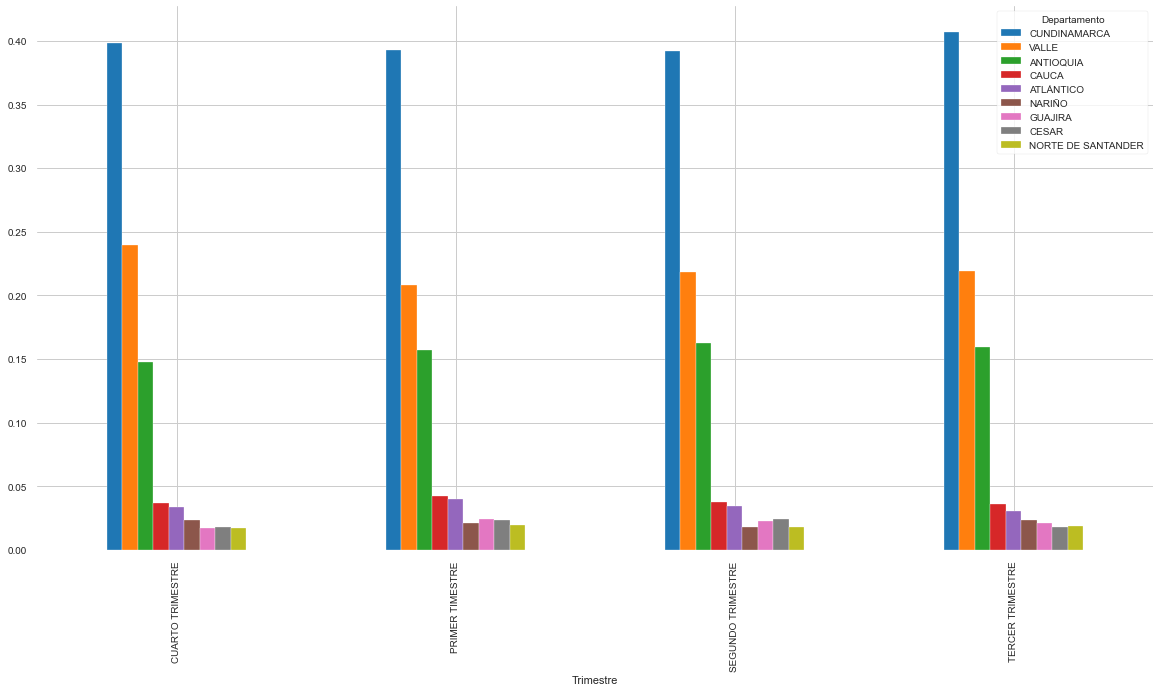

In [9]:
df_hurtos_mes_detartamento_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [10]:
chi2, p, dof, ex = chi2_contingency(df_hurtos_mes_detartamento_c)

if (p < 0.05):
    print('Existe una relación entre el mes y el robo de un vehículo')
    print(p)
else:
    print('No existe una relación entre el mes y el robo de un vehículo')

Existe una relación entre el mes y el robo de un vehículo
0.007095186267741113


## Trimestre VS Arma Empleada

In [11]:
df_hurtos_mes_arma_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos['Arma empleada'],margins=True)
df_hurtos_mes_arma_c_ = df_hurtos_mes_arma_c.T.sort_values("All", ascending=False).T.iloc[:,:10]
df_hurtos_mes_arma_c_ = df_hurtos_mes_arma_c_.div(df_hurtos_mes_arma_c_.All, axis=0)
df_hurtos_mes_arma_c_ = df_hurtos_mes_arma_c_.drop(['All'], axis=1).drop(['All'], axis=0)

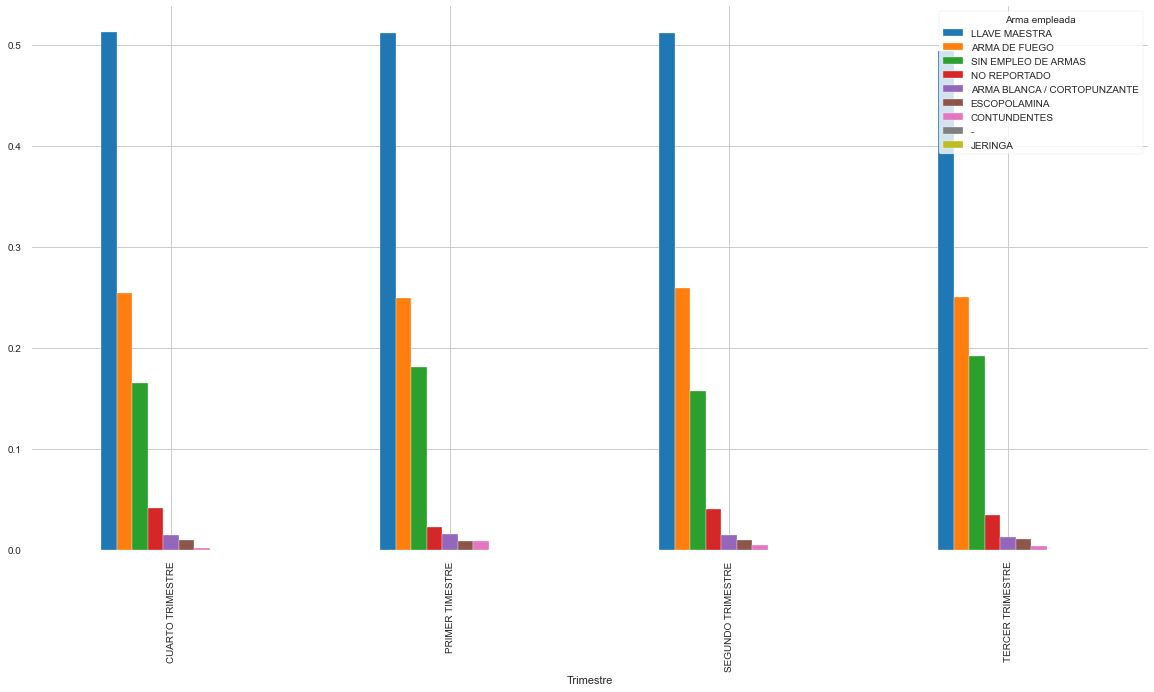

In [12]:
df_hurtos_mes_arma_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [13]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_arma_c)

if (p < 0.05):
    print('Existe una relación entre el mes y el tipo de arma usada para robar vehículos')
    print(p)
else:
    print('No existe una relación entre el mes y el tipo de arma usada para robar vehículos')

Existe una relación entre el mes y el tipo de arma usada para robar vehículos
2.0080835746880383e-17


## Trimestre vs Sitio

In [14]:
df_hurtos_mes_sitio_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos["Clase de sitio"],margins=True)
df_hurtos_mes_sitio_c_ = df_hurtos_mes_sitio_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_mes_sitio_c_ = df_hurtos_mes_sitio_c_.div(df_hurtos_mes_sitio_c_.All, axis=0)
df_hurtos_mes_sitio_c_ = df_hurtos_mes_sitio_c_.drop(["All"],axis=1).drop(["All"],axis=0)

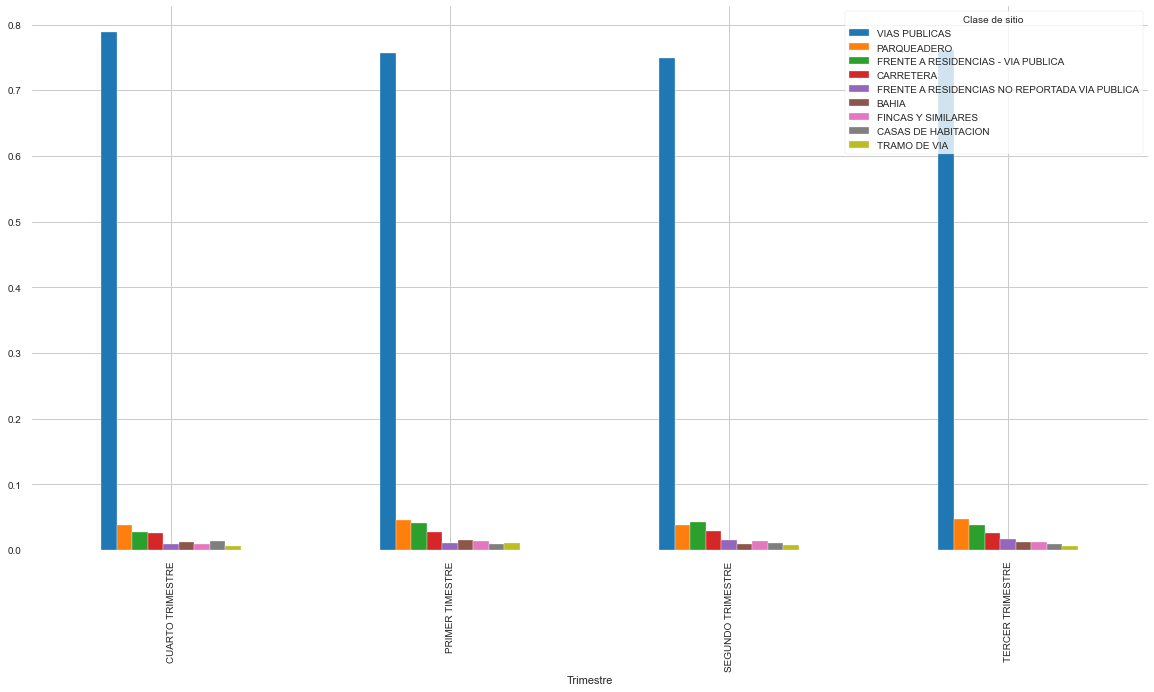

In [15]:
df_hurtos_mes_sitio_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [16]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_sitio_c)

if (p < 0.05) :
    print('Existe una relación entre el mes y el sitio propenso para robar vehículos')
    print(p)
else :
    print('No existe una relación entre el mes y el sitio propenso para robar vehículos')

Existe una relación entre el mes y el sitio propenso para robar vehículos
6.205085826686794e-08


## Trimestre vs Grupo Etario

In [17]:
df_hurtos_mes_getario_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos["Grupo_Etario"],margins=True)
df_hurtos_mes_getario_c_ = df_hurtos_mes_getario_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_mes_getario_c_ = df_hurtos_mes_getario_c_.div(df_hurtos_mes_getario_c_["All"],axis=0)
df_hurtos_mes_getario_c_ = df_hurtos_mes_getario_c_.drop(["All"],axis=1).drop(["All"],axis=0)

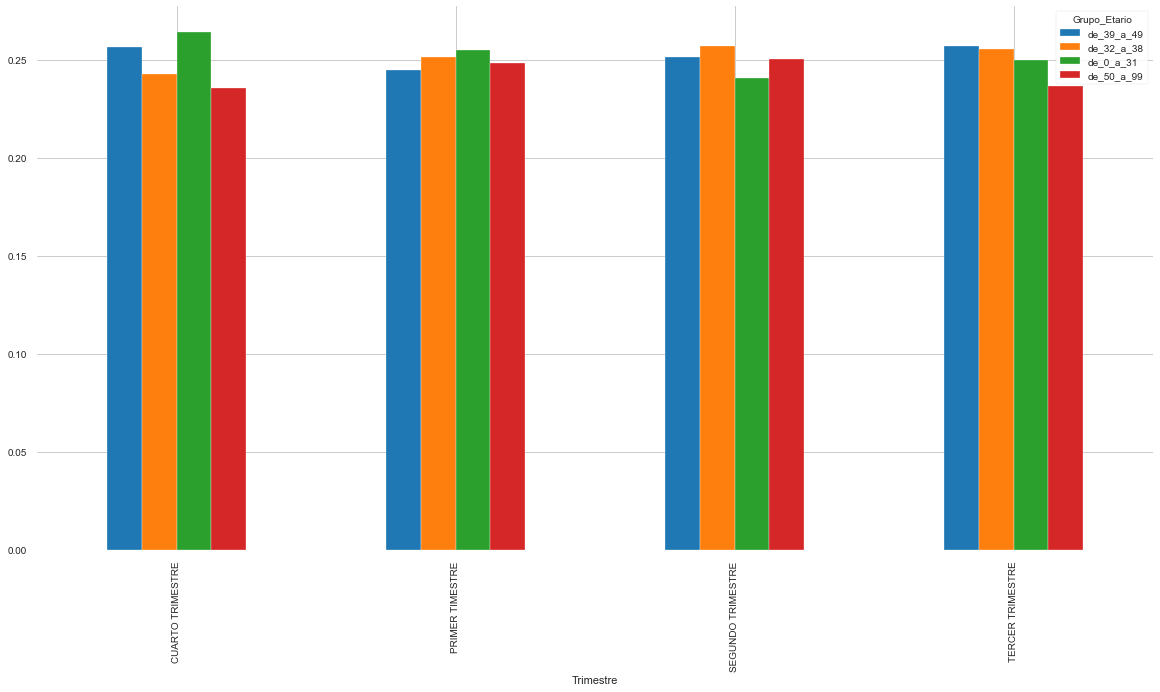

In [18]:
df_hurtos_mes_getario_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [20]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_mes_getario_c)

if (p < 0.05) :
    print('Existe una relación entre el mes y el grupo etario para robar vehículos')
    print(p)
else :
    print('No existe una relación entre el mes y el grupo etario para robar vehículos')

No existe una relación entre el mes y el grupo etario para robar vehículos


## Trimestre vs Género

In [91]:
df_hurtos_mes_sexo_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos["Sexo"],margins=True)
df_hurtos_mes_sexo_c_ = df_hurtos_mes_sexo_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_mes_sexo_c_ = df_hurtos_mes_sexo_c_.div(df_hurtos_mes_sexo_c_["All"],axis=0)
df_hurtos_mes_sexo_c_ = df_hurtos_mes_sexo_c_.drop(["All"],axis=1).drop(["All"],axis=0)

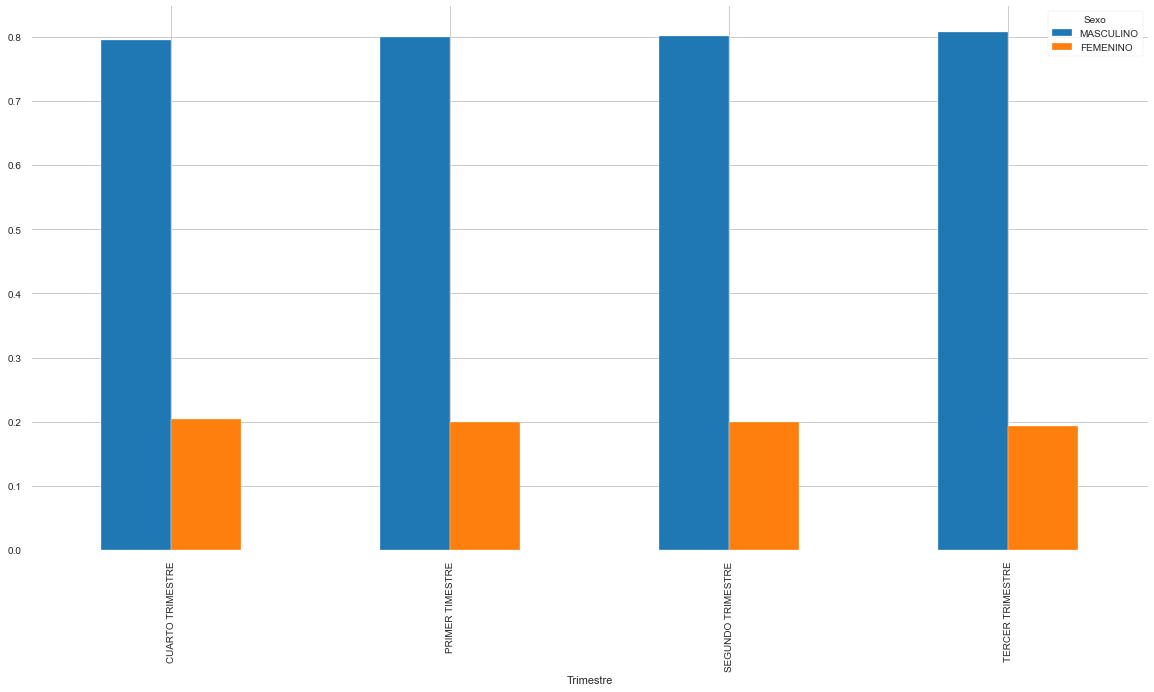

In [92]:
df_hurtos_mes_sexo_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [99]:
chi2, p, dof, ex = chi2_contingency(df_hurtos_mes_sexo_c)

if (p < 0.05) :
    print('Existe una relación entre el mes y el género a que se le roban vehículos')
    print(p)
else :
    print('No existe una relación entre el mes y el género a que se le roban vehículos')

No existe una relación entre el mes y el género a que se le roban vehículos


## Trimestre vs Marca

In [94]:
df_hurtos_mes_marca_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos["MARCA"],margins=True)
df_hurtos_mes_marca_c_ = df_hurtos_mes_marca_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_mes_marca_c_ = df_hurtos_mes_marca_c_.div(df_hurtos_mes_marca_c_["All"],axis=0)
df_hurtos_mes_marca_c_ = df_hurtos_mes_marca_c_.drop(["All"],axis=1).drop(["All"],axis=0)

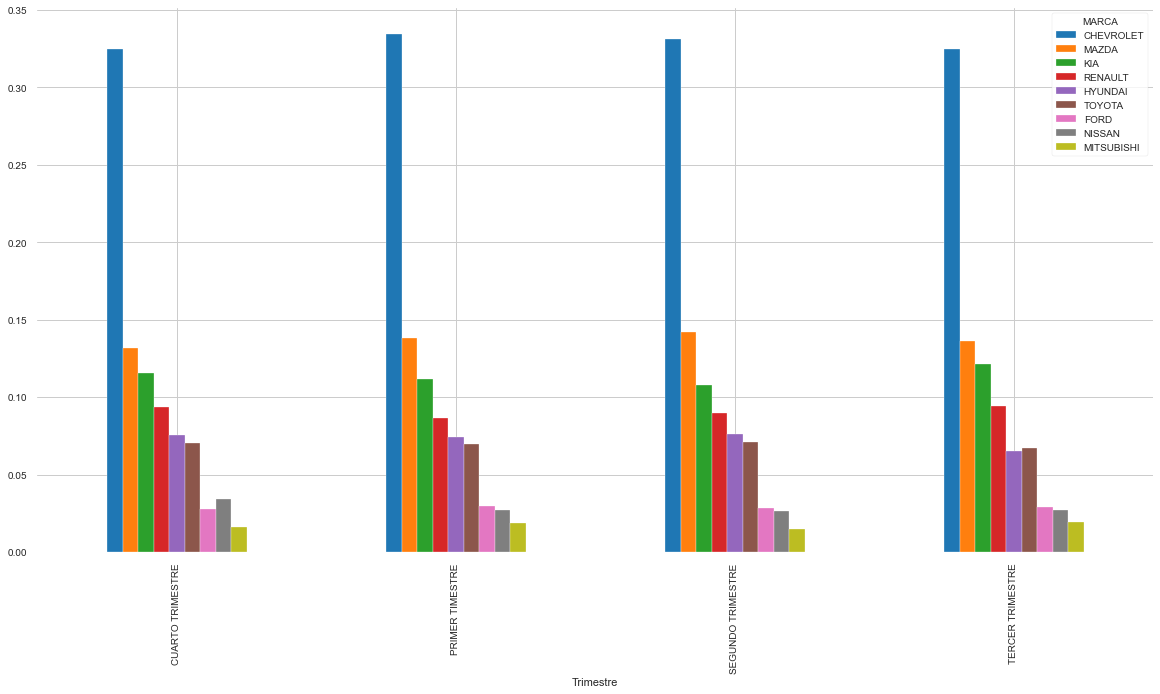

In [95]:
df_hurtos_mes_marca_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [97]:
chi2, p, dof, ex = chi2_contingency(df_hurtos_mes_marca_c)

if (p < 0.05) :
    print('Existe una relación entre el mes y la marca de vehículos robados')
    print(p)
else :
    print('No existe una relación entre el mes y la marca de vehículos robados')

No existe una relación entre el mes y la marca de vehículos robados


## Trimestre vs Hora

In [100]:
df_hurtos_mes_hora_c = pd.crosstab(index=df_hurtos["Trimestre"],columns=df_hurtos["Hora_Cat"],margins=True)
df_hurtos_mes_hora_c_ = df_hurtos_mes_hora_c.T.sort_values("All", ascending=False).iloc[:10].T
df_hurtos_mes_hora_c_ = df_hurtos_mes_hora_c_.div(df_hurtos_mes_hora_c_["All"],axis=0)
df_hurtos_mes_hora_c_ = df_hurtos_mes_hora_c_.drop(["All"],axis=1).drop(["All"],axis=0)

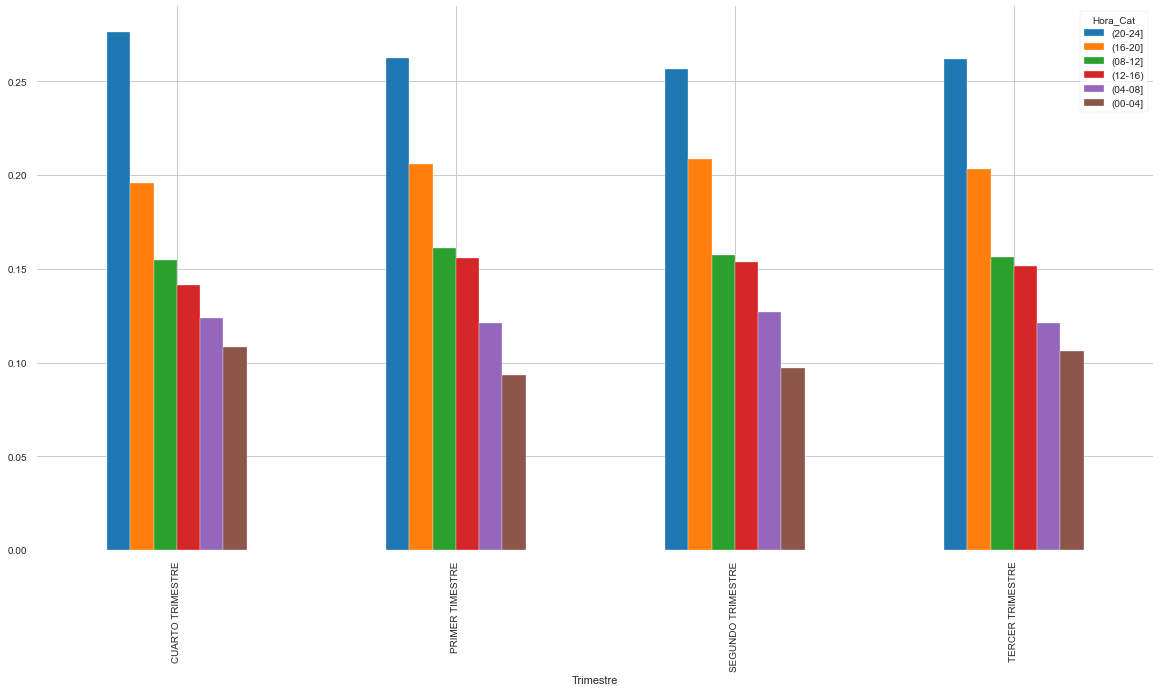

In [101]:
df_hurtos_mes_hora_c_.plot(kind='bar',figsize=(20,10),legend=True)

In [103]:
chi2, p, dof, ex = chi2_contingency(df_hurtos_mes_hora_c)

if (p < 0.05) :
    print('Existe una relación entre el mes y la hora en la que se roban vehículos')
    print(p)
else :
    print('No existe una relación entre el mes y la hora en la que se roban vehículos')

No existe una relación entre el mes y la hora en la que se roban vehículos


## Análisis Multivariado



#### Para el análisis multivariado se tendrán en cuenta aquellas variables que tuvieron algún tipo de relación con la temporalidad. Aquellas, que a través de la prueba de chi2 no tengan relación no serán incluídas en éste análisis.

Las variables relacionadas tienen que ver con el Departamento, el arma y el sitio. Por otro lado, con el fin de acotar el análisis, de la variable Departamento se hará un análisis propio por los tres primeros departamentos individualmente, es decir, un análisis individual por Cundinamarca, Valle y Antioquia. De las otras dos variables, se escogerán aquellos valores que sean más significativos. Es necesario destacar que la información se encuentra en función de los 4 trimestres por lo que será complejo concluir en un análisis general a que trimestre pertenece. Una opción es filtrar la información por semestres tal como se construye a nivel de departamento, sin embargo, para no extender y confundir el análisis se precisa no realizarlo pero si, dejarlo en conocimiento.

Este análisis se realizó usando la técnica de PCA, la cual se basa en describir un conjunto de datos en términos de componentes. Éstos componentes pueden reunir una proporción de la varianza de todo el conjunto de datos y usualmente se busca conocer la cantidad de componentes que expliquen el 95% de la varianza. Para el ejercicio, buscamos el 90% y para poder interpretar cada una de las técnicas, se hizo un análisis de correlación de Spearman entre el valor de cada una de las variables resultantes del crosstable (en porcentaje) con el valor de cada componente, esto nos permitiría conocer de algún modo la participación de una variable en dicha componente.

Además, los resultados se ven ampliamente sesgados por uno de los sitios como se observó en las gráficas anteriores por lo que se realizó un doble análisis conservando y eliminando este nivel (VÍA PÚBLICA), para observar el cambio en el análisis.

### Análisis Multivariado - Cundinamarca

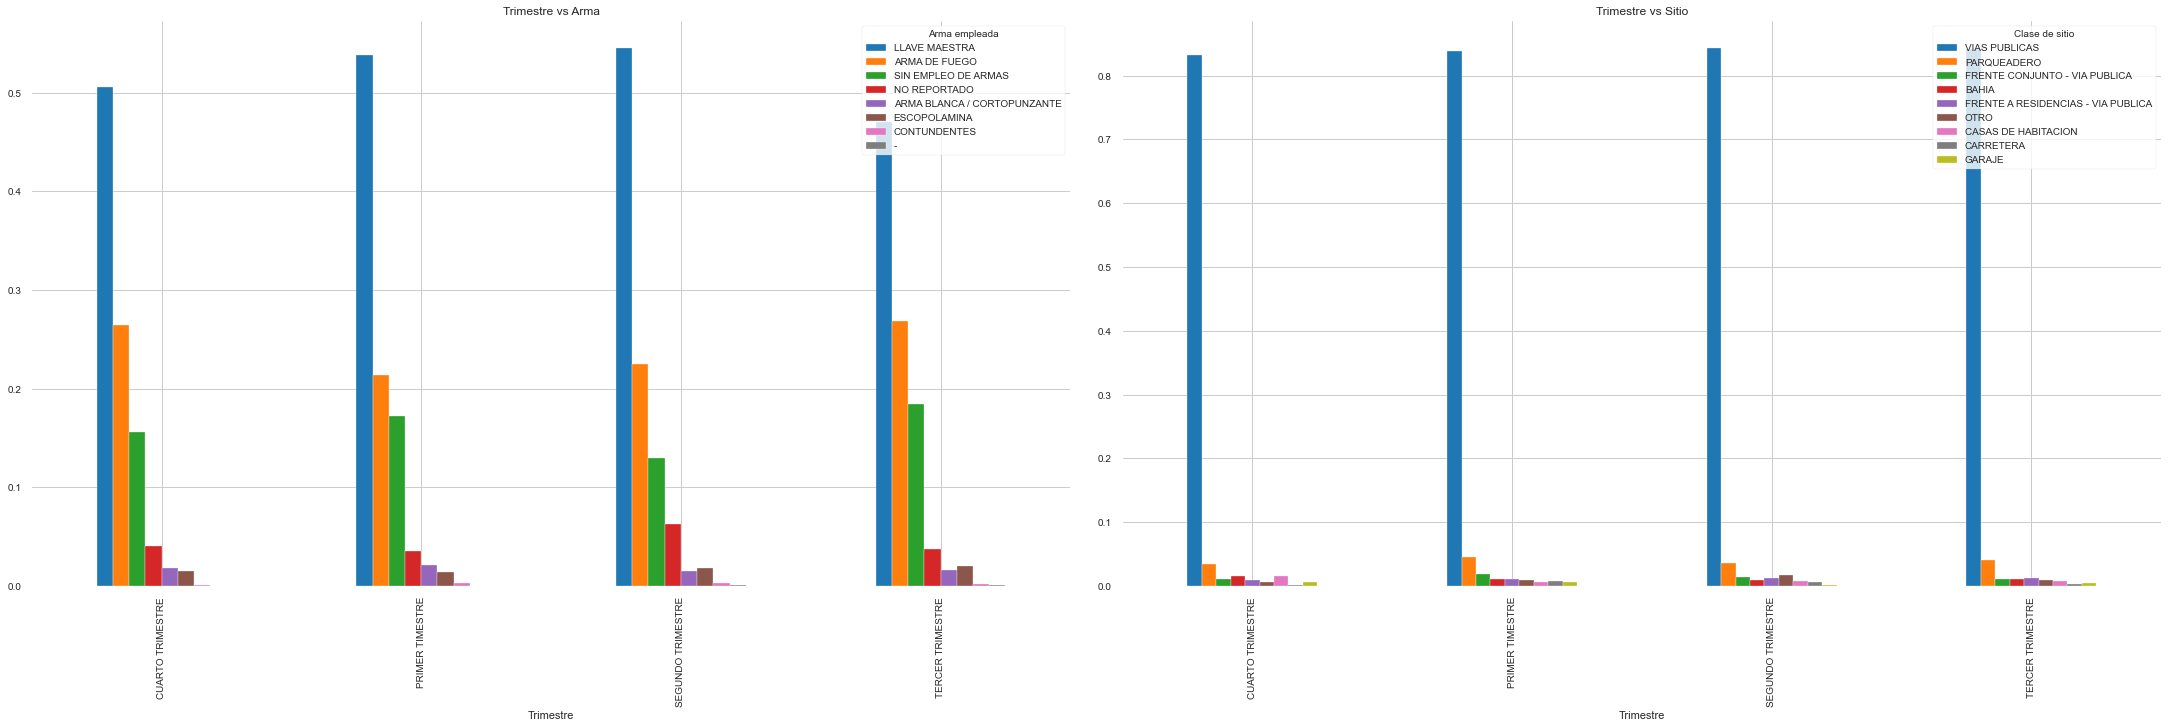

In [164]:
cu_df_hurtos = df_hurtos.loc[df_hurtos["Departamento"].isin(["CUNDINAMARCA"])]

cu_df_hurtos_mes_arma_c = pd.crosstab(index=cu_df_hurtos["Trimestre"],columns=cu_df_hurtos['Arma empleada'],margins=True)
cu_df_hurtos_mes_arma_c_ = cu_df_hurtos_mes_arma_c.T.sort_values("All", ascending=False).T.iloc[:,:10]
cu_df_hurtos_mes_arma_c_ = cu_df_hurtos_mes_arma_c_.div(cu_df_hurtos_mes_arma_c_.All, axis=0).drop(['All'], axis=1).drop(['All'], axis=0)

cu_df_hurtos_mes_sitio_c = pd.crosstab(index=cu_df_hurtos["Trimestre"],columns=cu_df_hurtos["Clase de sitio"],margins=True)
cu_df_hurtos_mes_sitio_c_ = cu_df_hurtos_mes_sitio_c.T.sort_values("All", ascending=False).iloc[:10].T
cu_df_hurtos_mes_sitio_c_ = cu_df_hurtos_mes_sitio_c_.div(cu_df_hurtos_mes_sitio_c_.All, axis=0).drop(["All"],axis=1).drop(["All"],axis=0)

fig, (ax1, ax2) = pyplot.subplots(1, 2, constrained_layout=True, figsize=(30,10))
cu_df_hurtos_mes_arma_c_.plot(kind="bar",ax=ax1, title="Trimestre vs Arma")
cu_df_hurtos_mes_sitio_c_.plot(kind="bar",ax=ax2, title="Trimestre vs Sitio")

In [163]:
df_cu = pd.concat([cu_df_hurtos_mes_arma_c_.iloc[:,:3],cu_df_hurtos_mes_sitio_c_.iloc[:,:3]],axis=1)
multivariate_performance(df_cu)

,CORR_PCA_COMPONENT_0,CORR_PCA_COMPONENT_1
LLAVE MAESTRA,-1.0,0.0
ARMA DE FUEGO,0.8,-0.4
SIN EMPLEO DE ARMAS,0.8,0.6
VIAS PUBLICAS,-0.4,0.2
PARQUEADERO,0.0,1.0
FRENTE CONJUNTO - VIA PUBLICA,-0.8,0.4


In [173]:
df_cu = pd.concat([cu_df_hurtos_mes_arma_c_.iloc[:,:3],cu_df_hurtos_mes_sitio_c_.iloc[:,1:4]],axis=1)
multivariate_performance(df_cu)

,CORR_PCA_COMPONENT_0,CORR_PCA_COMPONENT_1
LLAVE MAESTRA,-1.0,-0.4
ARMA DE FUEGO,0.8,-0.2
SIN EMPLEO DE ARMAS,0.8,0.8
PARQUEADERO,0.0,0.8
FRENTE CONJUNTO - VIA PUBLICA,-0.8,0.2
BAHIA,0.4,0.4


Del componente principal incluyendo el sitio VIAS PUBLICAS, se puede intuir que existe una aumento en el uso de armas de fuego y el no empleo de armas en sitios diferentes a VIAS PUBLICAS y/o frente a conjuntos para el hurto a vehículos ya que cuando aumentan estas dos primeras las dos segundas disminuyen, por otro lado el segundo componente nos da a intuir, que la mayor cantidad de robos de auto que se producen en parqueaderos se realizan sin el empleo de armas. Sin el sitio VIAS PUBLICAS, el escenario del primer componente no difere pero en el segundo componente se refuerza el mismo escenario.

### Análisis Multivariado - Valle

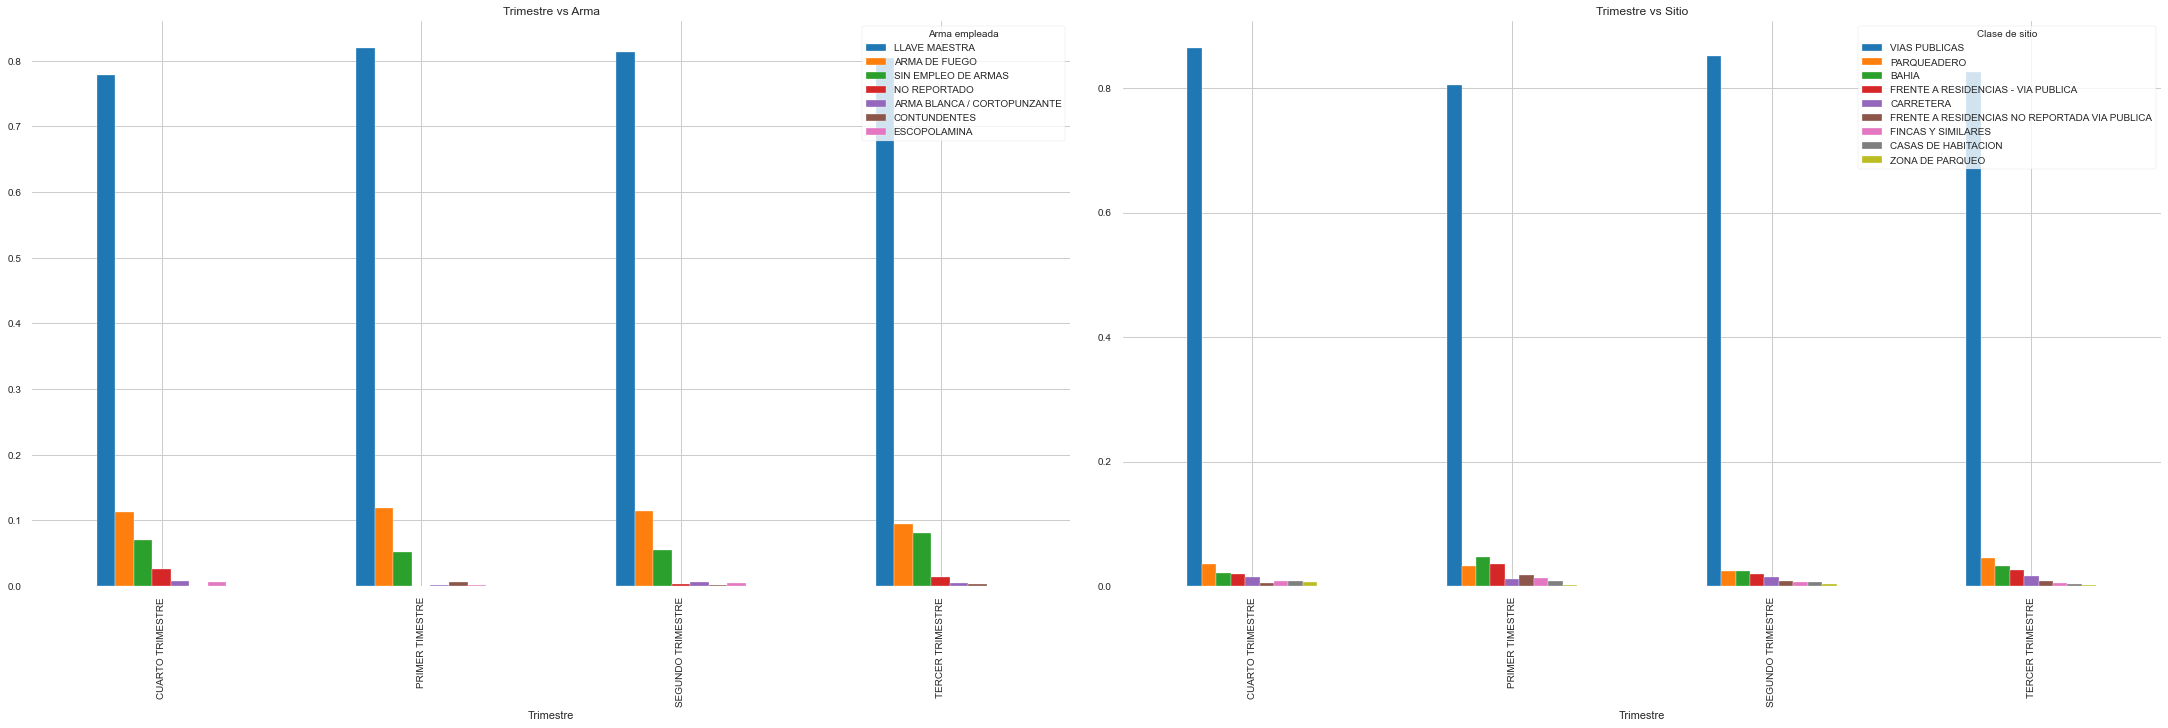

In [165]:
va_df_hurtos = df_hurtos.loc[df_hurtos["Departamento"].isin(["VALLE"])]

va_df_hurtos_mes_arma_c = pd.crosstab(index=va_df_hurtos["Trimestre"],columns=va_df_hurtos['Arma empleada'],margins=True)
va_df_hurtos_mes_arma_c_ = va_df_hurtos_mes_arma_c.T.sort_values("All", ascending=False).T.iloc[:,:10]
va_df_hurtos_mes_arma_c_ = va_df_hurtos_mes_arma_c_.div(va_df_hurtos_mes_arma_c_.All, axis=0).drop(['All'], axis=1).drop(['All'], axis=0)

va_df_hurtos_mes_sitio_c = pd.crosstab(index=va_df_hurtos["Trimestre"],columns=va_df_hurtos["Clase de sitio"],margins=True)
va_df_hurtos_mes_sitio_c_ = va_df_hurtos_mes_sitio_c.T.sort_values("All", ascending=False).iloc[:10].T
va_df_hurtos_mes_sitio_c_ = va_df_hurtos_mes_sitio_c_.div(va_df_hurtos_mes_sitio_c_.All, axis=0).drop(["All"],axis=1).drop(["All"],axis=0)

fig, (ax1, ax2) = pyplot.subplots(1, 2, constrained_layout=True, figsize=(30,10))
va_df_hurtos_mes_arma_c_.plot(kind="bar",ax=ax1, title="Trimestre vs Arma")
va_df_hurtos_mes_sitio_c_.plot(kind="bar",ax=ax2, title="Trimestre vs Sitio")

In [166]:
df_va = pd.concat([va_df_hurtos_mes_arma_c_.iloc[:,:3],va_df_hurtos_mes_sitio_c_.iloc[:,:3]],axis=1)
multivariate_performance(df_va)

,CORR_PCA_COMPONENT_0,CORR_PCA_COMPONENT_1
LLAVE MAESTRA,0.8,-0.6
ARMA DE FUEGO,0.4,-0.8
SIN EMPLEO DE ARMAS,-0.4,0.8
VIAS PUBLICAS,-1.0,0.0
PARQUEADERO,0.0,1.0
BAHIA,1.0,0.0


In [175]:
df_va = pd.concat([va_df_hurtos_mes_arma_c_.iloc[:,:3],va_df_hurtos_mes_sitio_c_.iloc[:,1:4]],axis=1)
multivariate_performance(df_va)

,CORR_PCA_COMPONENT_0,CORR_PCA_COMPONENT_1
LLAVE MAESTRA,1.0,0.4
ARMA DE FUEGO,0.8,-0.2
SIN EMPLEO DE ARMAS,-0.8,0.2
PARQUEADERO,-0.6,0.4
BAHIA,0.8,0.8
FRENTE A RESIDENCIAS - VIA PUBLICA,0.8,0.8


En el Valle, es interesante como el primer componente se ve positivamente correlacionado con el uso de las llaves maestra, y el robo en de autos en Bahías o frente a residencias, en el escenario sin VIAS PUBLICAS el primer componente refuerza el uso de armas de fuego. Del segundo componente con VIAS PUBLICAS existe una relación fuerte en el robo de autos en parqueaderos sin el uso de armas. Del escenario sin VIAS PUBLICAS del segundo componente no es clara las relación entre las variables.

### Análisis Multivariado - Antioquia

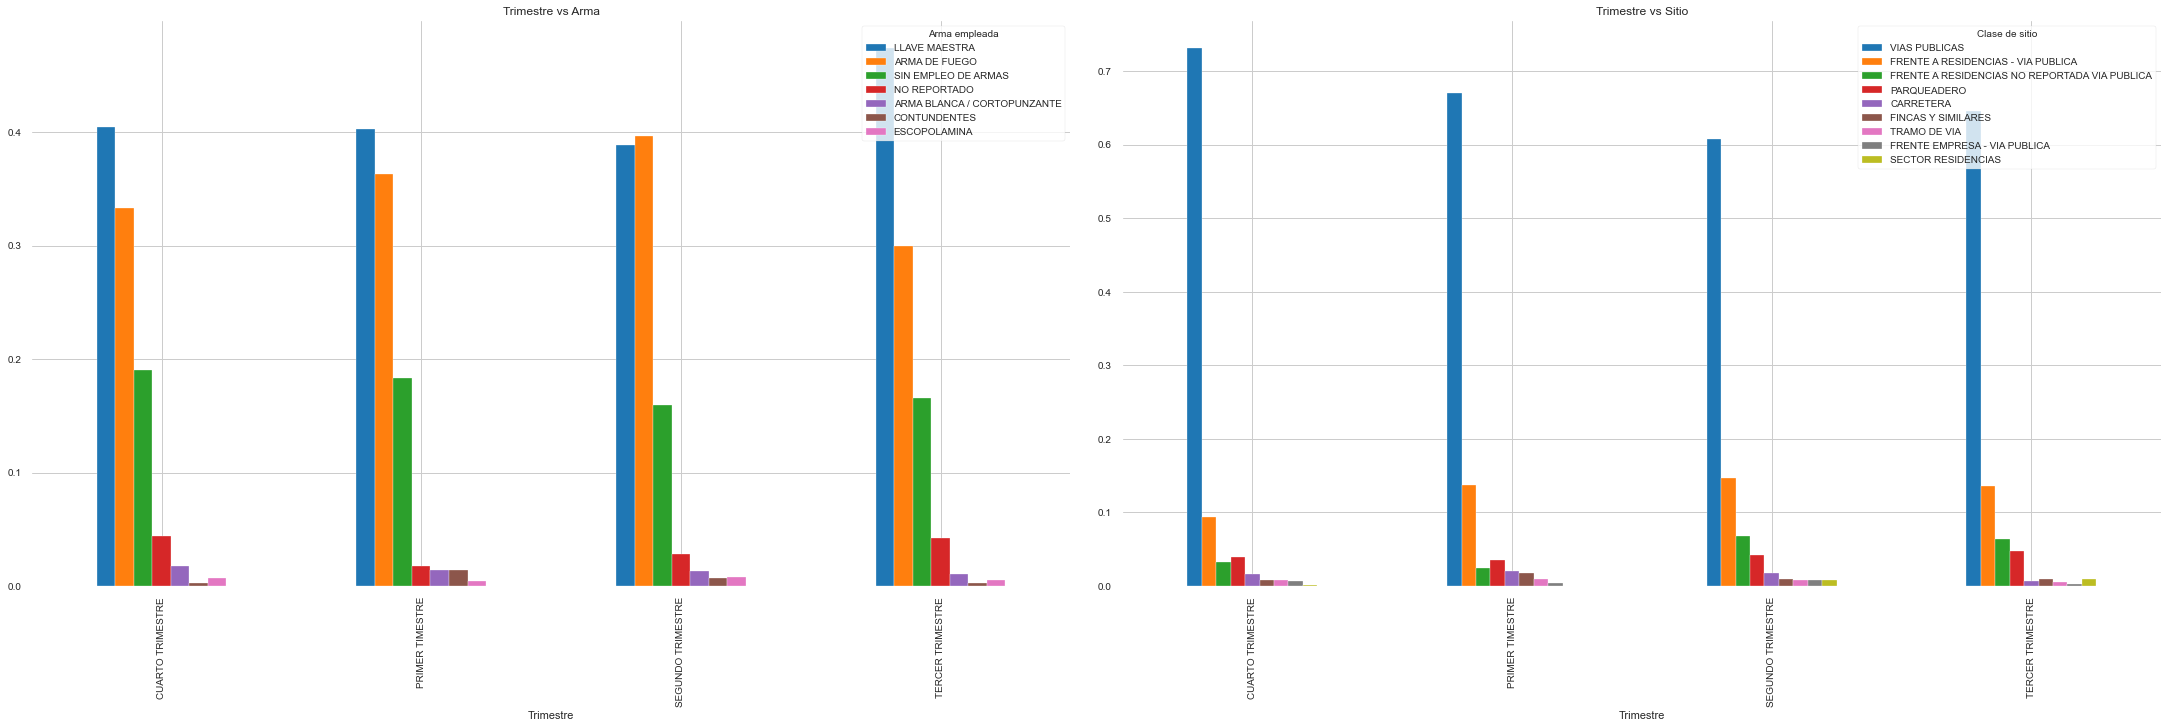

In [167]:
an_df_hurtos = df_hurtos.loc[df_hurtos["Departamento"].isin(["ANTIOQUIA"])]

an_df_hurtos_mes_arma_c = pd.crosstab(index=an_df_hurtos["Trimestre"],columns=an_df_hurtos['Arma empleada'],margins=True)
an_df_hurtos_mes_arma_c_ = an_df_hurtos_mes_arma_c.T.sort_values("All", ascending=False).T.iloc[:,:10]
an_df_hurtos_mes_arma_c_ = an_df_hurtos_mes_arma_c_.div(an_df_hurtos_mes_arma_c_.All, axis=0).drop(['All'], axis=1).drop(['All'], axis=0)

an_df_hurtos_mes_sitio_c = pd.crosstab(index=an_df_hurtos["Trimestre"],columns=an_df_hurtos["Clase de sitio"],margins=True)
an_df_hurtos_mes_sitio_c_ = an_df_hurtos_mes_sitio_c.T.sort_values("All", ascending=False).iloc[:10].T
an_df_hurtos_mes_sitio_c_ = an_df_hurtos_mes_sitio_c_.div(an_df_hurtos_mes_sitio_c_.All, axis=0).drop(["All"],axis=1).drop(["All"],axis=0)

fig, (ax1, ax2) = pyplot.subplots(1, 2, constrained_layout=True, figsize=(30,10))
an_df_hurtos_mes_arma_c_.plot(kind="bar",ax=ax1, title="Trimestre vs Arma")
an_df_hurtos_mes_sitio_c_.plot(kind="bar",ax=ax2, title="Trimestre vs Sitio")

In [170]:
df_an = pd.concat([an_df_hurtos_mes_arma_c_.iloc[:,:3],an_df_hurtos_mes_sitio_c_.iloc[:,:3]],axis=1)
multivariate_performance(df_an)

,CORR_PCA_COMPONENT_0,CORR_PCA_COMPONENT_1
LLAVE MAESTRA,-0.8,0.2
ARMA DE FUEGO,0.8,-0.2
SIN EMPLEO DE ARMAS,-0.8,-0.8
VIAS PUBLICAS,-0.8,-0.8
FRENTE A RESIDENCIAS - VIA PUBLICA,1.0,0.4
FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,0.4,0.6


In [176]:
df_an = pd.concat([an_df_hurtos_mes_arma_c_.iloc[:,:3],an_df_hurtos_mes_sitio_c_.iloc[:,1:4]],axis=1)
multivariate_performance(df_an)

,CORR_PCA_COMPONENT_0,CORR_PCA_COMPONENT_1
LLAVE MAESTRA,1.0,0.4
ARMA DE FUEGO,-1.0,-0.4
SIN EMPLEO DE ARMAS,0.4,1.0
FRENTE A RESIDENCIAS - VIA PUBLICA,-0.8,-0.8
FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,-0.2,-0.8
PARQUEADERO,0.4,-0.6


En antioquía se puede evidenciar el cambio del escenario con VIAS PUBLICAS al escenario sin este nivel. En el primer escenario, el primer componente deja entre ver la fuerte relación que existe el hurto de autos frente a residencias con el uso de armas de fuego, mientras que los robos de autos se reducen en vias públicas y el uso de armas convencionales o el no uso de armas para cometer el delito. El componente dos, deja en evidencia la reducción en general el robo de autos. Esto confirma las conclusiones del análisis para Cundinamarca y Valle si se observa el gráfico general de robos por departamento.